# Interpretability using dog and cat classification

In this notebook, we do a binary classification task between photos of dogs and cats. This then enables us to explore MONAI's interpretability classes, `OcclusionSensitivity` and `GradCAM`.

The data used here is available on Kaggle: https://www.kaggle.com/karakaggle/kaggle-cat-vs-dog-dataset.

We use a pre-trained Densenet, which enables us to do very quick training. For brevity, we also don't bother with splitting into training and validation datasets.

In [1]:
!pip install -q ipywidgets==7.6

from glob import glob
import os
from enum import Enum
import torch
from monai.transforms import (
    AsChannelFirstd,
    Compose,
    DivisiblePadd,
    LoadImaged,
    Rotate90d,
    ScaleIntensityd,
)
from monai.networks.utils import eval_mode, train_mode
from contextlib import nullcontext
from matplotlib import pyplot as plt
from monai.data import Dataset, DataLoader
from monai.networks.nets import DenseNet121
from monai.data.utils import pad_list_data_collate
from random import shuffle
import numpy as np
from tqdm.notebook import tqdm, trange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from monai.visualize import (
    GradCAM,
    GradCAMpp,
    OcclusionSensitivity,
    VanillaGrad,
    SmoothGrad,
    GuidedBackpropGrad,
    GuidedBackpropSmoothGrad,
)
from monai.transforms.utils import rescale_array
from monai.utils import set_determinism

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_determinism(0)

If you download the dataset from the abovementioned link, please set the `directory` to the path to `PetImages/`. For example:

```
directory = "/root_dir/kagglecatsanddogs_3367a/PetImages/"
```

and comment the following cell.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
assert os.path.isdir(directory)
directory = os.path.join(directory, "CatsAndDogs")
assert os.path.isdir(directory)

In [3]:
class Animals(Enum):
    cat = 0
    dog = 1


def remove_non_rgb(data, max_num=None):
    """Some images are grayscale or rgba. For simplicity, remove them."""
    loader = LoadImaged("image")
    out = []
    for i in data:
        im = loader(i)["image"]
        if im.ndim == 3 and im.shape[-1] == 3:
            out.append(i)
        if max_num is not None and len(out) == max_num:
            return out
    return out


def get_data(animal, max_num=None):
    files = glob(os.path.join(directory, animal.name.capitalize(), "*.jpg"))
    data = [{"image": i, "label": animal.value} for i in files]
    shuffle(data)
    data = remove_non_rgb(data, max_num)
    return data


# 500 of each class as this is sufficient
cats, dogs = [get_data(i, max_num=500) for i in Animals]
data = cats + dogs
shuffle(data)

print(f"Num im cats: {len(cats)}")
print(f"Num im dogs: {len(dogs)}")
print(f"Num images to be used: {len(data)}")

Num im cats: 500
Num im dogs: 500
Num images to be used: 1000


In [4]:
batch_size = 20
divisible_factor = 20
transforms = Compose([
    LoadImaged("image"),
    AsChannelFirstd("image"),
    ScaleIntensityd("image"),
    Rotate90d("image", k=3),
    DivisiblePadd("image", k=divisible_factor)
])

ds = Dataset(data, transforms)
dl = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10,
    collate_fn=pad_list_data_collate,
    drop_last=True,
)

In [5]:
def imshow(data):
    nims = len(data)
    if nims < 6:
        shape = (1, nims)
    else:
        shape = int(np.floor(np.sqrt(nims))), int(np.ceil(np.sqrt(nims)))
    fig, axes = plt.subplots(*shape, figsize=(20, 20))
    axes = np.asarray(axes) if nims == 1 else axes
    for d, ax in zip(data, axes.ravel()):
        # channel last for matplotlib
        im = np.moveaxis(d["image"], 0, -1)
        ax.imshow(im, cmap='gray')
        ax.set_title(Animals(d['label']).name, fontsize=25)
        ax.axis("off")
    plt.show()

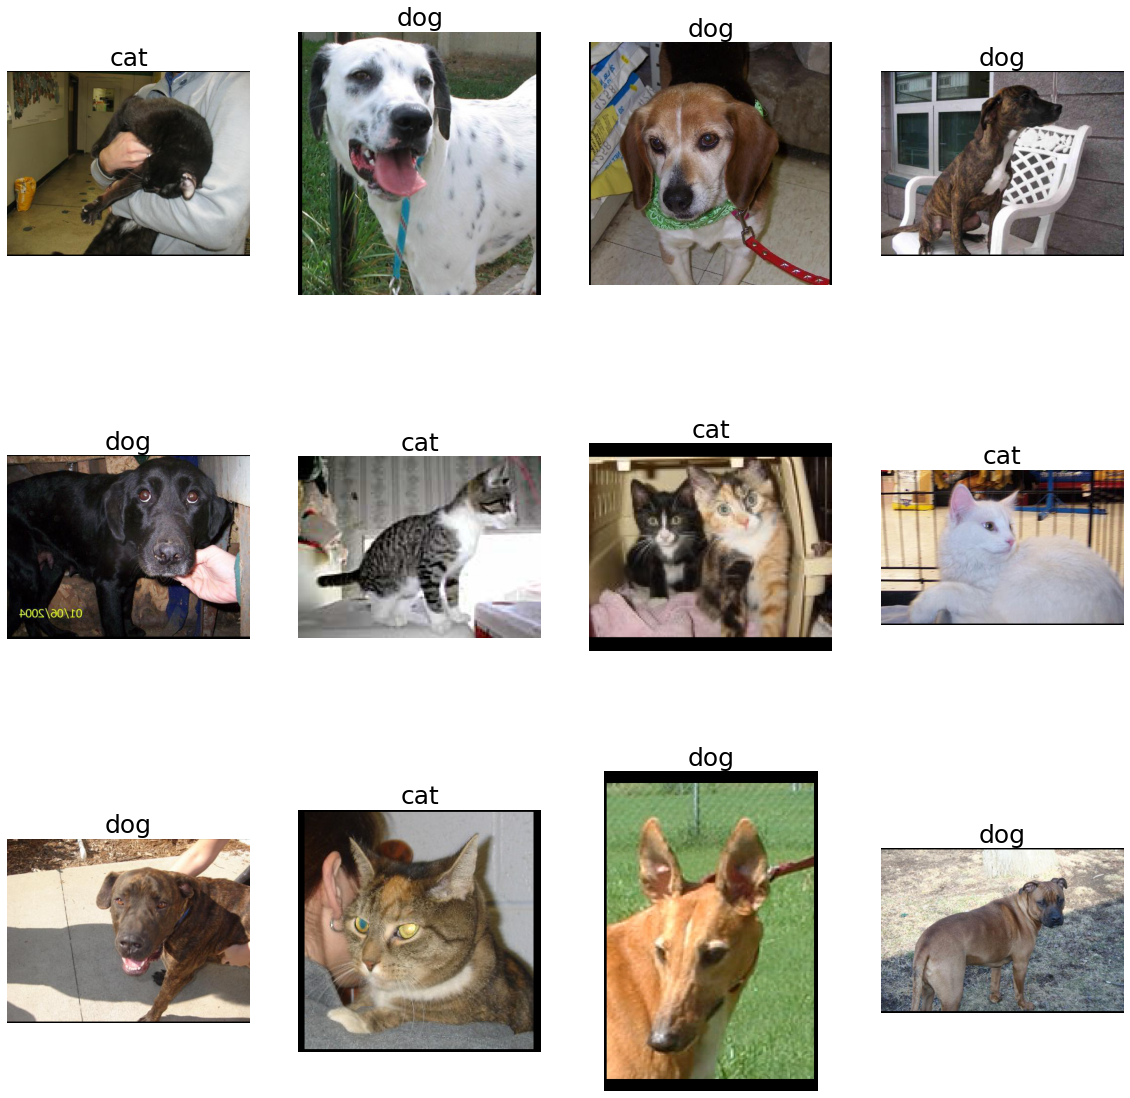

In [6]:
# Random images
rand_idxs = np.random.choice(len(ds), size=12, replace=False)
imshow([ds[i] for i in rand_idxs])

In [12]:
model = DenseNet121(
    spatial_dims=2, in_channels=3, out_channels=2, pretrained=True
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
use_amp = True
label_dtype = torch.float16 if use_amp else torch.float32
scaler = torch.cuda.amp.GradScaler() if use_amp else None


def criterion(y_pred, y):
    return torch.nn.functional.cross_entropy(y_pred, y, reduction="sum")


def get_num_correct(y_pred, y):
    return (y_pred.argmax(dim=1) == y).sum().item()

In [13]:
max_epochs = 2
for epoch in trange(max_epochs, desc="Epoch"):
    loss, acc = 0, 0
    for data in dl:
        inputs, labels = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast() if use_amp else nullcontext():
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            acc += get_num_correct(outputs, labels)
        if use_amp:
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        loss += train_loss.item()
    loss /= (len(dl) * batch_size)
    acc /= (len(dl) * batch_size)
    print(f"Epoch {epoch+1}, loss: {loss:.3f}, acc: {acc:.4f}")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, loss: 0.561, acc: 0.7850
Epoch 2, loss: 0.331, acc: 0.9630


  0%|          | 0/50 [00:00<?, ?it/s]

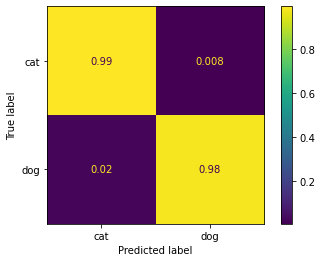

In [14]:
with eval_mode(model):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for data in tqdm(dl):
        images, labels = data["image"].to(device), data["label"].to(device)
        with torch.cuda.amp.autocast() if use_amp else nullcontext():
            outputs = model(images).detach()
        y_pred = torch.cat([y_pred, outputs], dim=0)
        y = torch.cat([y, labels], dim=0)

    y_pred = y_pred.argmax(dim=1)

    cm = confusion_matrix(
        y.cpu().numpy(),
        y_pred.cpu().numpy(),
        normalize='true',
    )
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[a.name for a in Animals],
    )
    _ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Interpretability

Now we compare `OcclusionSensitivity` and `GradCAM`. When the network infers the correct class, blue areas imply that importance in the decision making process.

In [15]:
# for name, _ in model.named_modules(): print(name)
target_layer = "class_layers.relu"
gradcam = GradCAM(model, target_layers=target_layer)
gradcampp = GradCAMpp(model, target_layers=target_layer)
occ_sens = OcclusionSensitivity(
    model, mask_size=50, n_batch=batch_size, stride=divisible_factor, per_channel=False
)
vanilla_grad = VanillaGrad(model)
smooth_grad = SmoothGrad(model)
guided_vanilla = GuidedBackpropGrad(model)
guided_smooth = GuidedBackpropSmoothGrad(model)

Computing occlusion sensitivity: 100%|██████████| 475/475 [00:03<00:00, 153.16it/s]


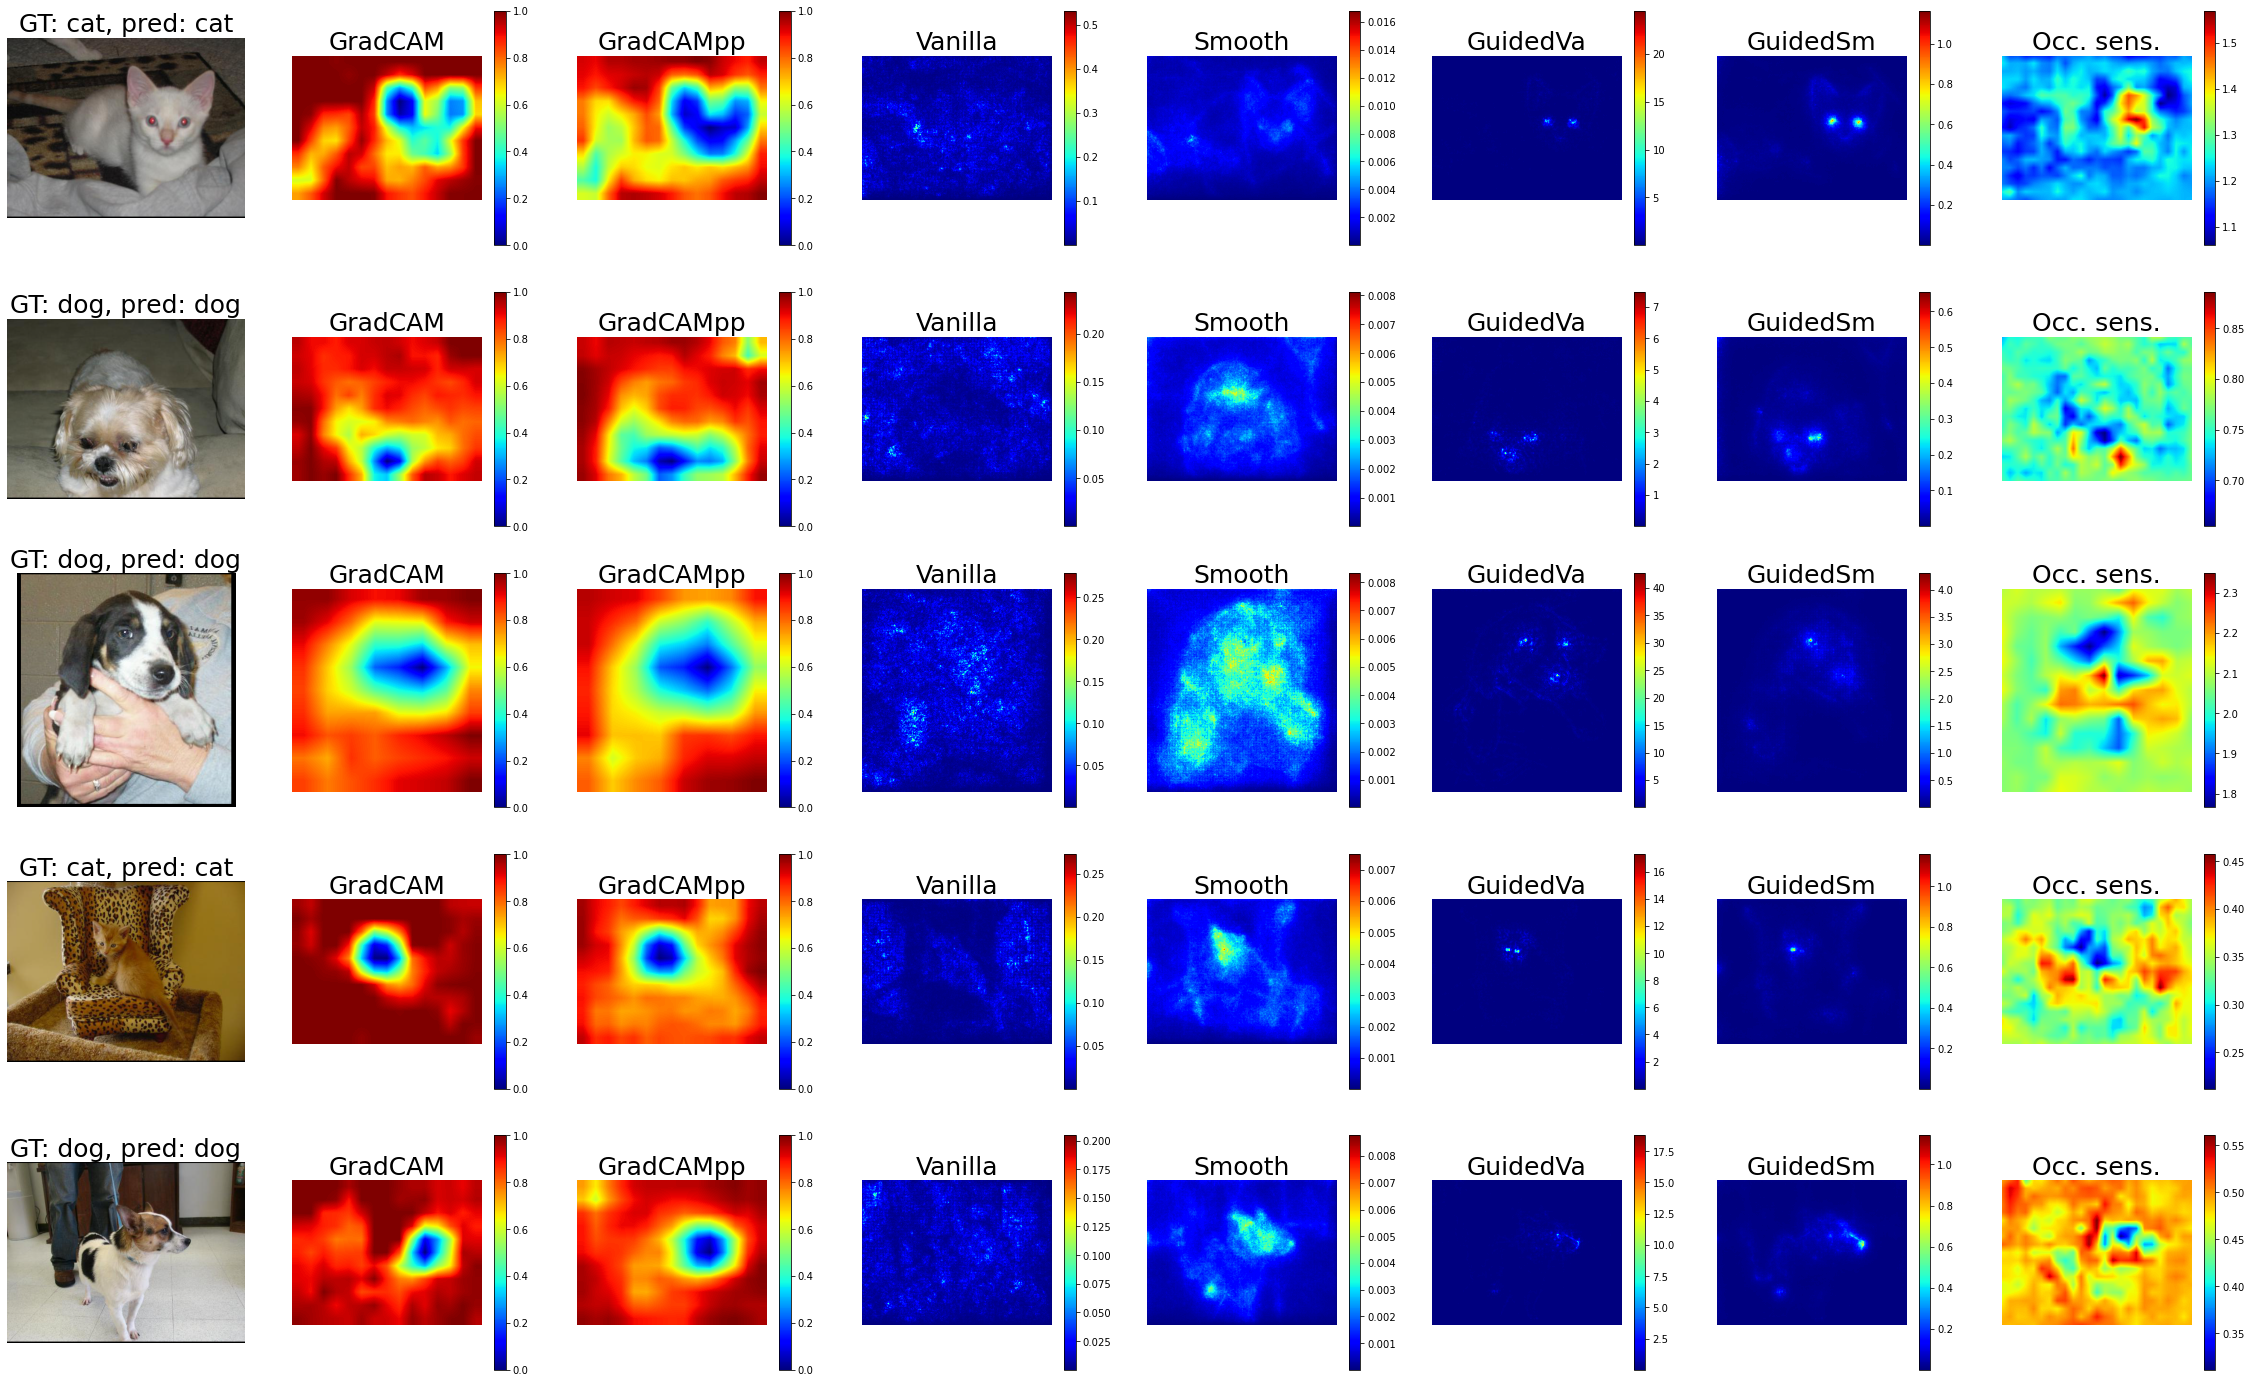

In [16]:
model.eval()
num_examples = 5
num_cols = 8
subplot_shape = [num_examples, num_cols]
figsize = [i * 5 for i in subplot_shape][::-1]
fig, axes = plt.subplots(
    *subplot_shape, figsize=figsize, facecolor='white'
)

rand_data = np.random.choice(ds, replace=False, size=num_examples)
for row, d in enumerate(rand_data):

    ims = []
    titles = []

    img = torch.as_tensor(d["image"])[None].to(device)
    label = d["label"]
    pred_label = model(img).argmax(dim=1).item()
    # Image
    ims.append(torch.moveaxis(img, 1, -1))
    titles.append(f"GT: {Animals(label).name}, pred: {Animals(pred_label).name}")

    # GradCAM
    res_cam = gradcam(x=img, class_idx=pred_label)[0]
    ims.append(res_cam)
    titles.append("GradCAM")

    res_cam_pp = gradcampp(x=img, class_idx=pred_label)[0]
    ims.append(res_cam_pp)
    titles.append("GradCAMpp")

    # other gradient-based approaches
    for method, name in zip(
        (vanilla_grad, smooth_grad, guided_vanilla, guided_smooth),
        ("Vanilla", "Smooth", "GuidedVa", "GuidedSm")
    ):
        out = method(img)
        out = torch.sum(out ** 2, dim=1) ** 0.5  # RGB -> scalar
        ims.append(out)
        titles.append(name)

    # Occlusion sensitivity images
    occ_map = occ_sens(img)[0][0]
    ims.append(occ_map[..., pred_label])
    titles.append("Occ. sens.")

    for col, (im, title) in enumerate(zip(ims, titles)):
        ax = axes[row, col] if num_examples > 1 else axes[col]
        if isinstance(im, torch.Tensor):
            im = im.detach().cpu()
        im_show = ax.imshow(im[0], cmap='jet')
        ax.set_title(title, fontsize=25)
        ax.axis("off")
        if col > 0:
            fig.colorbar(im_show, ax=ax)